# Box Office Predictions

## Goal:

#### Importing Libraries and Packages

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from wordcloud import WordCloud
from collections import Counter
from scipy.stats import skew, boxcox
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
plt.style.use('ggplot')
import re
import yaml
import json
from nltk.corpus import stopwords

### Loading Training Data

In [34]:
train = pd.read_csv('train.csv')

In [37]:
#Json format columns to dictionary format.
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [38]:
train = text_to_dict(train)

In [39]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


### Loading Testing Data

In [40]:
test = pd.read_csv('test.csv')
test = text_to_dict(test)

In [41]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,{},6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


# Exploratory Data Analysis

c:\python37\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


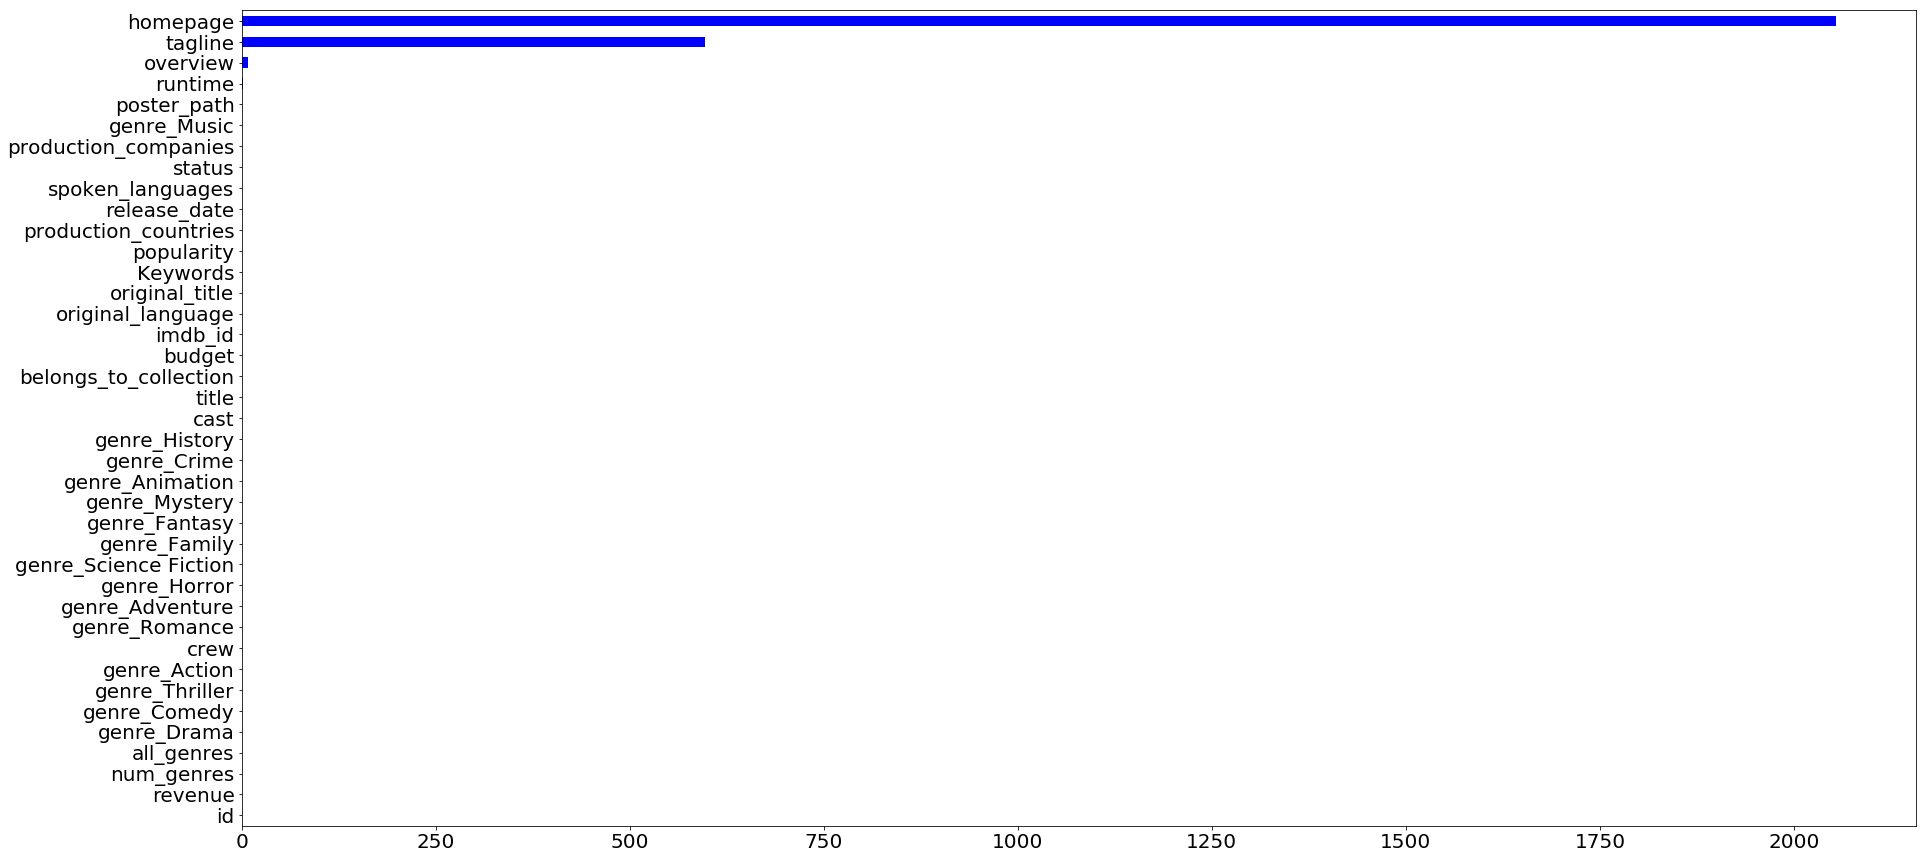

In [61]:
#Counting Null Values in the Training Dataset
fig = plt.figure(figsize=(30, 15))
train.isna().sum().sort_values(ascending=True).plot(kind='barh',colors='Blue', fontsize=20)

c:\python37\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


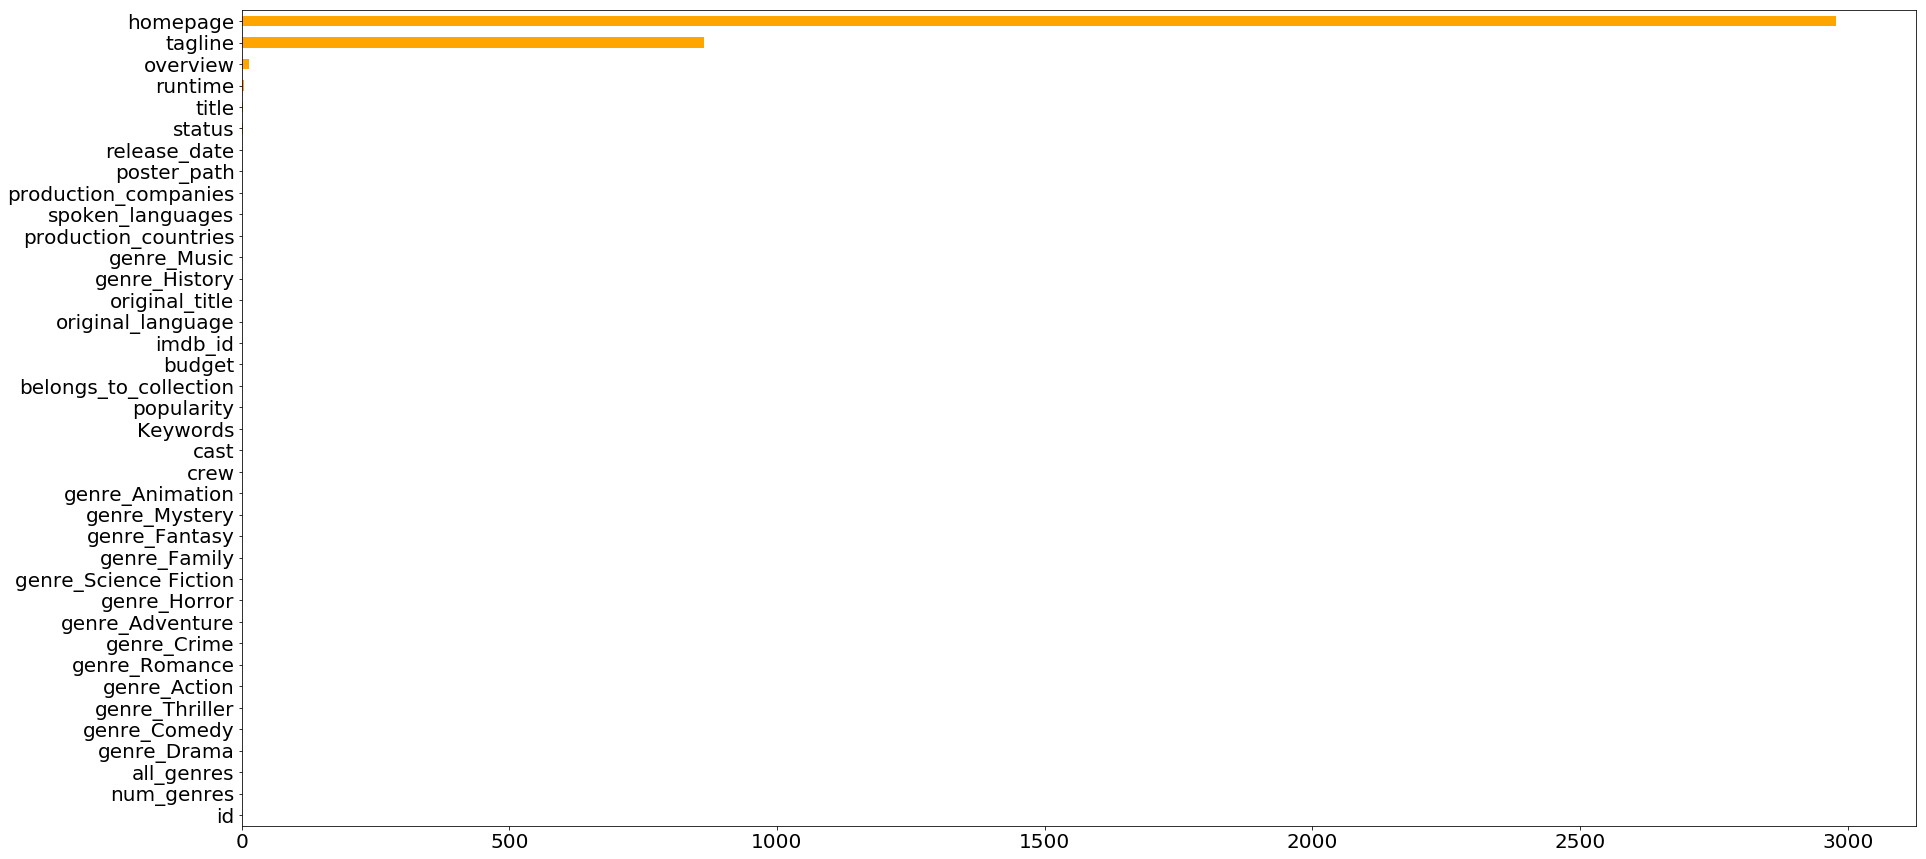

In [62]:
#Counting Null Values in the Testing Dataset
fig = plt.figure(figsize=(30, 15))
test.isna().sum().sort_values(ascending=True).plot(kind='barh',colors='Orange', fontsize=20)

In [63]:
#To Date-Time Features
def date_features(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_quarter'] = df['release_date'].dt.quarter
    df.drop(columns=['release_date'], inplace=True)
    return df

train=date_features(train)
test=date_features(test)

train['release_year'].head(10)

0    2015
1    2004
2    2014
3    2012
4    2009
5    1987
6    2012
7    2004
8    1996
9    2003
Name: release_year, dtype: int64

In [64]:
train['release_year'].iloc[np.where(train['release_year']> 2019)][:10]

39     2065
41     2067
51     2065
61     2056
68     2062
109    2066
140    2068
144    2067
172    2066
187    2028
Name: release_year, dtype: int64

In [65]:
#Changing century for the records above 2019.
train['release_year']=np.where(train['release_year']> 2019, train['release_year']-100, train['release_year'])
test['release_year']=np.where(test['release_year']> 2019, test['release_year']-100, test['release_year'])

In [66]:
fillna_column = {'release_year':'mode','release_month':'mode',
                'release_day':'mode'}

for k,v in fillna_column.items():
    if v == 'mode':
        fill = train[k].mode()[0]
    else:
        fill = v
    print(k, ': ', fill)
    train[k].fillna(value = fill, inplace = True)
    test[k].fillna(value = fill, inplace = True)

release_year :  2013
release_month :  9
release_day :  1


In [67]:
def year_month_together(df):
    year = df["release_year"].astype(int).copy().astype(str)
    month=df['release_month'].astype(int).copy().astype(str)
    day=df['release_day'].astype(int).copy().astype(str) 
    df["release_date"]=  month.str.cat(day.str.cat(year,sep="/"), sep ="/") 
    df['release_date']=pd.to_datetime(df['release_date'],format="%m/%d/%Y")
    df['release_dow'] = df['release_date'].dt.dayofweek
    return df 

train=year_month_together(train)
test=year_month_together(test)

train['release_date'].head(10)

0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
5   1987-08-06
6   2012-08-30
7   2004-01-15
8   1996-02-16
9   2003-04-16
Name: release_date, dtype: datetime64[ns]

In [71]:
#Plotting the count of movies released during the years.
d1 = train['release_date'].value_counts().sort_index()
d2 = test['release_date'].value_counts().sort_index()
data = [go.Histogram(x=d1.index, y=d1.values, name='train'), go.Histogram(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of release_date",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [ ]:
#Observation:- We can see that rate of movies got higher and higher after year 2000.

Text(0, 0.5, 'Revenue (100 million dollars)')

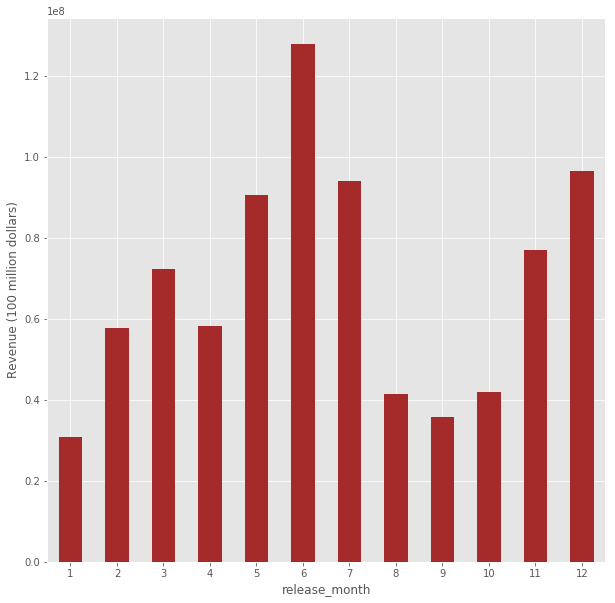

In [78]:
#Plotting the graph between Release month and average revenue obtained during that month.
fig = plt.figure(figsize=(10,10))

train.groupby('release_month').agg('mean')['revenue'].plot(kind='bar',color='brown',rot=0)
plt.ylabel('Revenue (100 million dollars)')

In [ ]:
#Observation:- We see that revenue is highest if the movie is released in June followed by December, we can conclude that 
# People watch more movies in holiday season.

Text(0.5, 1.0, 'Mean Popularity Over Years')

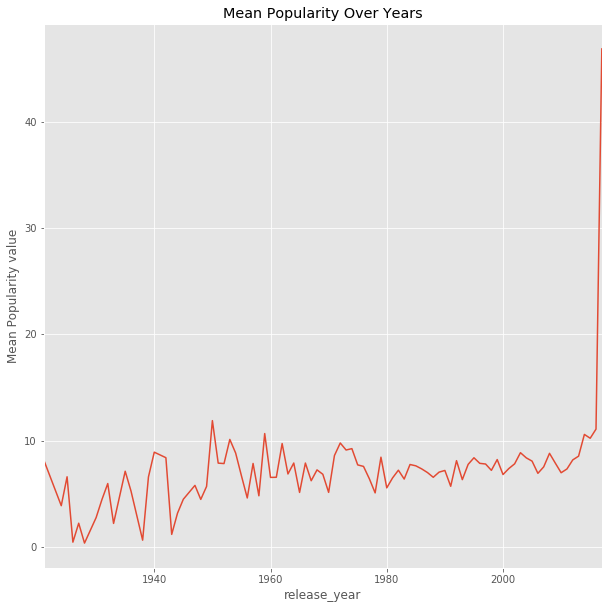

In [79]:
#Plotting release_year vs mean popularity during that year.
release_year_mean_data=train.groupby(['release_year'])['budget','popularity','revenue'].mean()
release_year_mean_data.head()

fig = plt.figure(figsize=(10, 10))
release_year_mean_data['popularity'].plot(kind='line')
plt.ylabel('Mean Popularity value')
plt.title('Mean Popularity Over Years')

In [ ]:
#Observation :- This shows that mean popularity increases over the years.

Text(0.5, 0, 'Popularity of the Movie')

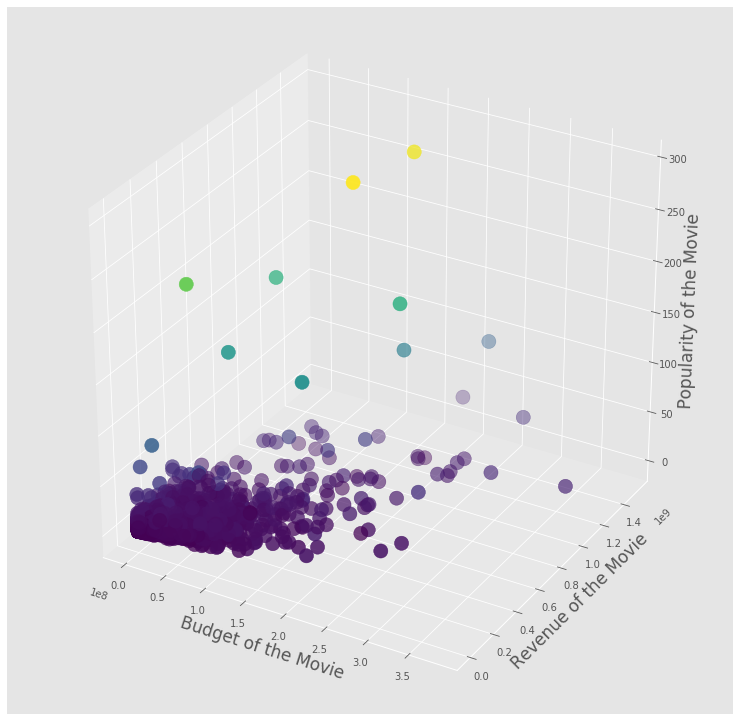

In [80]:
#3D plot between budget popularity and revenue, showing they have strong correlation with each other.
release_year_mean_data=train.groupby(['release_year'])['budget','popularity','revenue'].mean()
release_year_mean_data.head()

fig = plt.figure(figsize=(13,13))
ax = plt.subplot(111,projection = '3d')

# Data for three-dimensional scattered points
zdata =train.popularity
xdata =train.budget
ydata = train.revenue
ax.scatter3D(xdata, ydata, zdata, c=zdata, s = 200)
ax.set_xlabel('Budget of the Movie',fontsize=17)
ax.set_ylabel('Revenue of the Movie',fontsize=17)
ax.set_zlabel('Popularity of the Movie',fontsize=17)

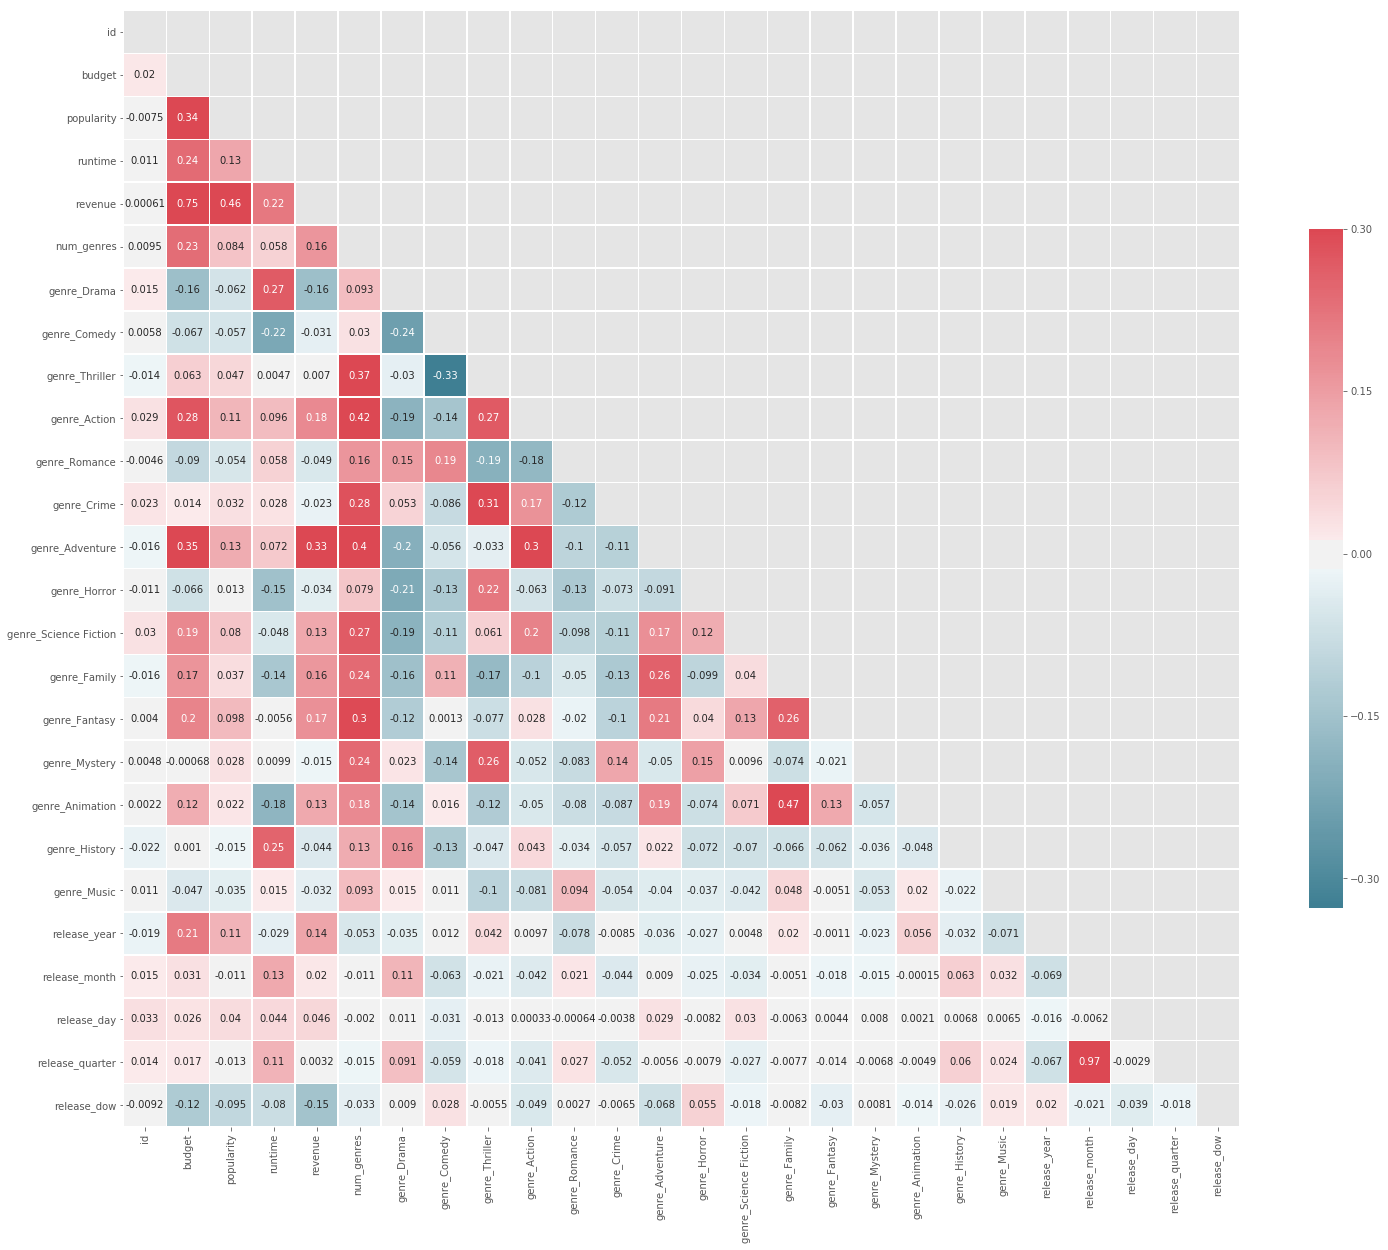

In [85]:
# Creating correlation matrix 

corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(25, 25))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [42]:
#Some Columns contain a list of dictionaries as values, so we look into them.

### Genres

In [43]:
for i, e in enumerate(train['genres'][:5]):
    print(i,e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [44]:
#Extracting List of all the genre names.
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

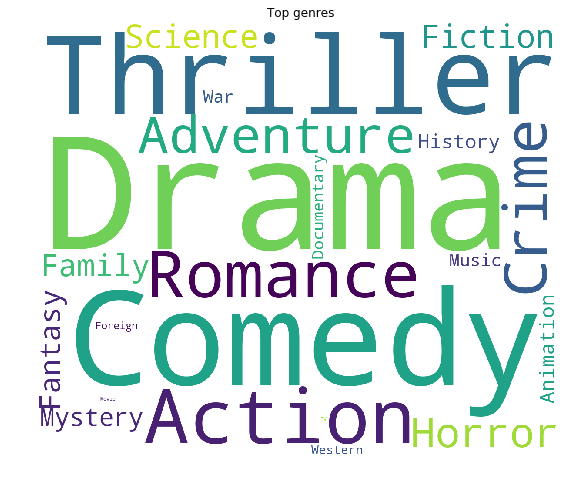

In [47]:
#Making a wordcloud of all the genres.
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

In [50]:
#Thriller, Drama, and comedy are most popular genres.
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

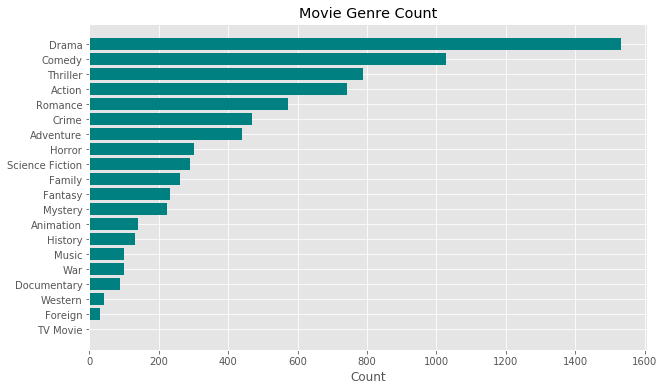

In [86]:
#Plot to show most common Genres.
most_common_genres=Counter([i for j in list_of_genres for i in j]).most_common()
fig = plt.figure(figsize=(10, 6))
data=dict(most_common_genres)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='teal')
plt.xlabel('Count')
plt.title('Movie Genre Count')
plt.show()

In [51]:
#Create Separate columns for top 15 genres.
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

### Belong_to_collection

In [87]:
# Counting NAs as 0
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [88]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

In [89]:
# Most common collection 
train['collection_name'].value_counts()[1:10]

James Bond Collection                     16
Friday the 13th Collection                 7
The Pink Panther (Original) Collection     6
Police Academy Collection                  5
Pokémon Collection                         5
Resident Evil Collection                   4
Ice Age Collection                         4
Rocky Collection                           4
The Fast and the Furious Collection        4
Name: collection_name, dtype: int64

### Movie Text Analysis

There are 48476 words in the combination of all review.


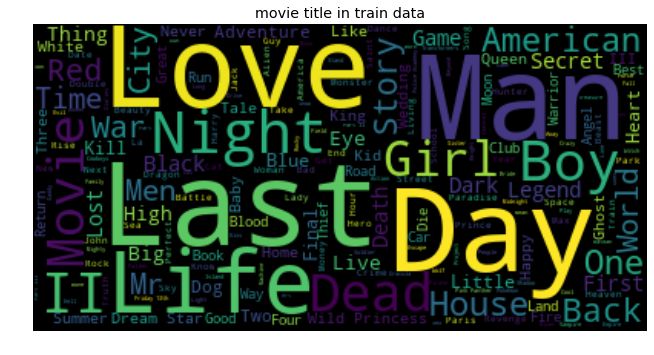

In [102]:
#Creating word cloud from movie titles.
text = " ".join(review for review in train.title)
print ("There are {} words in the combination of all review.".format(len(text)))

stopwords = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)

fig = plt.figure(figsize=(11, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('movie title in train data')
plt.axis("off")
plt.show()

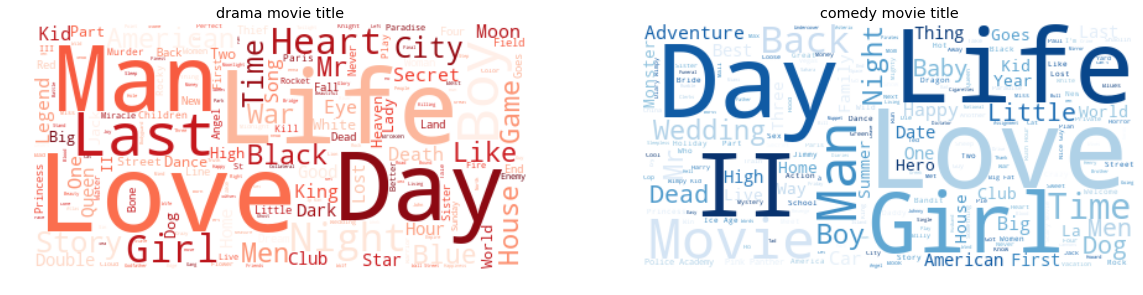

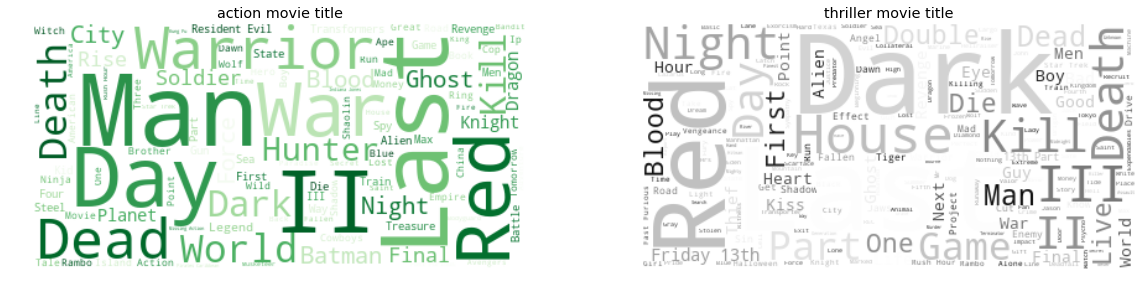

In [103]:
# Text analysis on top 4 movie genres title 

drama=train.loc[train['genre_Drama']==1,]
comedy=train.loc[train['genre_Comedy']==1,]
action=train.loc[train['genre_Action']==1,]
thriller=train.loc[train['genre_Thriller']==1,]



text_drama = " ".join(review for review in drama.title)
text_comedy = " ".join(review for review in comedy.title)
text_action = " ".join(review for review in action.title)
text_thriller = " ".join(review for review in thriller.title)


wordcloud1 = WordCloud(stopwords=stopwords, background_color="white",colormap="Reds").generate(text_drama)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white",colormap="Blues").generate(text_comedy)
wordcloud3 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greens").generate(text_action)
wordcloud4 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greys").generate(text_thriller)


fig = plt.figure(figsize=(20, 10))

plt.subplot(221)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('drama movie title')
plt.axis("off")

plt.subplot(222)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('comedy movie title')
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(20, 10))

plt.subplot(223)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.title('action movie title')
plt.axis("off")

plt.subplot(224)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.title('thriller movie title')
plt.axis("off")
plt.show()

In [104]:
#Grouping top four genres by release_year and Revenue they recieved.
drama_revenue=drama.groupby(['release_year']).mean()['revenue']
comedy_revenue=comedy.groupby(['release_year']).mean()['revenue']
action_revenue=action_revenue=action.groupby(['release_year']).mean()['revenue']
thriller_revenue=thriller.groupby(['release_year']).mean()['revenue']

revenue_concat = pd.concat([drama_revenue,comedy_revenue,action_revenue,thriller_revenue], axis=1)
revenue_concat.columns=['drama','comedy','action','thriller']
revenue_concat.index=train.groupby(['release_year']).mean().index

In [105]:
data = [go.Scatter(x=revenue_concat.index, y=revenue_concat.drama, name='drama'), go.Scatter(x=revenue_concat.index, y=revenue_concat.comedy, name='comedy'),
       go.Scatter(x=revenue_concat.index, y=revenue_concat.action, name='action'),go.Scatter(x=revenue_concat.index, y=revenue_concat.thriller, name='thriller')]
layout = go.Layout(dict(title = 'Mean Revenue by Top 4 Movie Genres Over Years',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Revenue'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [106]:
#Observation:- As you can see from the plot that Action is top earning genre from the four of them, but during 1970s to 1980s
#Thriller was doing really great.
#Maybe now people don't watch thriller that much.

### Production Companies

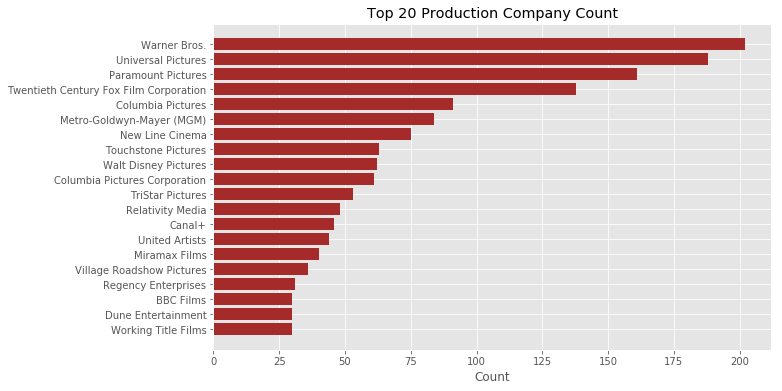

In [107]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_companies=Counter([i for j in list_of_companies for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_companies)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='brown')
plt.xlabel('Count')
plt.title('Top 20 Production Company Count')
plt.show()

In [108]:
#Observations:- We see that Warner Bros, Universal Pictures, Paramount Pictures and Twentieth Century Fox Film corporation are
#top four movie production companies.

In [109]:
#Doing label encoding for each production company.
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

Text(0.5, 0, 'Revenue (100 million dollars)')

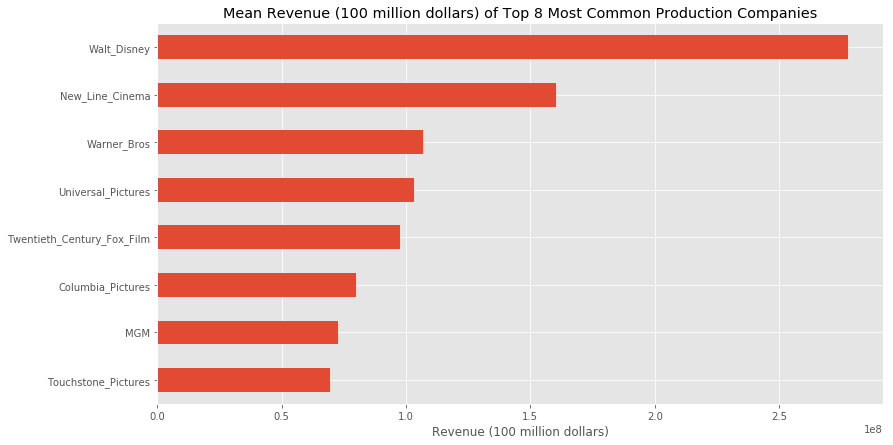

In [110]:
#Plotting for production companies and the mean revenue they generate. 
Warner_Bros=train.loc[train['production_company_Warner Bros.']==1,]
Universal_Pictures=train.loc[train['production_company_Universal Pictures']==1,]
Twentieth_Century_Fox_Film=train.loc[train['production_company_Twentieth Century Fox Film Corporation']==1,]
Columbia_Pictures=train.loc[train['production_company_Columbia Pictures']==1,]
MGM=train.loc[train['production_company_Metro-Goldwyn-Mayer (MGM)']==1,]
New_Line_Cinema=train.loc[train['production_company_New Line Cinema']==1,]
Touchstone_Pictures=train.loc[train['production_company_Touchstone Pictures']==1,]
Walt_Disney=train.loc[train['production_company_Walt Disney Pictures']==1,]

Warner_Bros_revenue=Warner_Bros.groupby(['release_year']).mean()['revenue']
Universal_Pictures_revenue=Universal_Pictures.groupby(['release_year']).mean()['revenue']
Twentieth_Century_Fox_Film_revenue=Twentieth_Century_Fox_Film.groupby(['release_year']).mean()['revenue']
Columbia_Pictures_revenue=Columbia_Pictures.groupby(['release_year']).mean()['revenue']
MGM_revenue=MGM.groupby(['release_year']).mean()['revenue']
New_Line_Cinema_revenue=New_Line_Cinema.groupby(['release_year']).mean()['revenue']
Touchstone_Pictures_revenue=Touchstone_Pictures.groupby(['release_year']).mean()['revenue']
Walt_Disney_revenue=Walt_Disney.groupby(['release_year']).mean()['revenue']


prod_revenue_concat = pd.concat([Warner_Bros_revenue,Universal_Pictures_revenue,Twentieth_Century_Fox_Film_revenue,Columbia_Pictures_revenue,
                                MGM_revenue,New_Line_Cinema_revenue,Touchstone_Pictures_revenue,Walt_Disney_revenue], axis=1)
prod_revenue_concat.columns=['Warner_Bros','Universal_Pictures','Twentieth_Century_Fox_Film','Columbia_Pictures','MGM','New_Line_Cinema','Touchstone_Pictures','Walt_Disney']

fig = plt.figure(figsize=(13, 7))
prod_revenue_concat.agg("mean",axis='rows').sort_values(ascending=True).plot(kind='barh',x='Production Companies',y='Revenue',title='Mean Revenue (100 million dollars) of Top 8 Most Common Production Companies')
plt.xlabel('Revenue (100 million dollars)')

In [111]:
#Observation:- We can see that Walt Disney is the most earning Production company.

In [112]:
#Plot for mean revenue of the top 8 production companies over the years.
data = [go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.Warner_Bros, name='Warner_Bros'), go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.Universal_Pictures, name='Universal_Pictures'),
       go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.Twentieth_Century_Fox_Film, name='Twentieth_Century_Fox_Film'),go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.Columbia_Pictures, name='Columbia_Pictures'),
       go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.MGM, name='MGM'), go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.New_Line_Cinema, name='New_Line_Cinema'),
       go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.Touchstone_Pictures, name='Touchstone_Pictures'),go.Scatter(x=prod_revenue_concat.index, y=prod_revenue_concat.Walt_Disney, name='Walt_Disney')]


layout = go.Layout(dict(title = 'Mean Revenue of Top 8 Movie Production Companies over Years',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Revenue'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [113]:
#Observation :- We see that MGM and New Line Chin production companies had almost same revenue of 1.02 Billions during years
#2010-2012 while they both came falling down over the course in 2017 it's shown that warner bros and walt disney were 
#Highest earning companies with a revenue of 8.25 Millions

### Production Countries

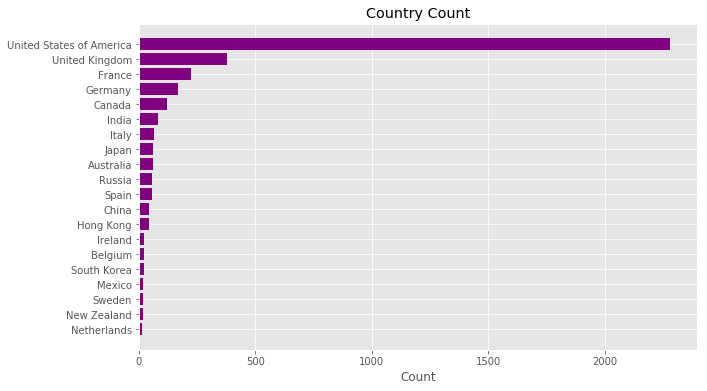

In [114]:
#Plot showing countries where most of the movies are produced
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
most_common_countries=Counter([i for j in list_of_countries for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_countries)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='purple')
plt.xlabel('Count')
plt.title('Country Count')
plt.show()

In [115]:
#Handling categorical value for each movie produced in a particular country
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

### Spoken Language

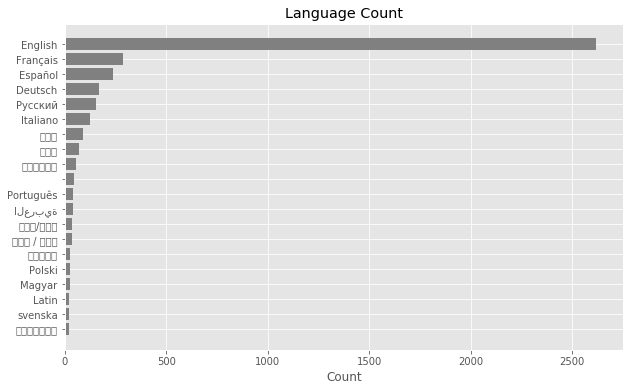

In [116]:
#Plot showing the most common languages spoken in movies.
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_languages=Counter([i for j in list_of_languages for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_languages)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='gray')
plt.xlabel('Count')
plt.title('Language Count')
plt.show()

In [117]:
#Observation:- We see that most of the movies are produced in english language.

In [118]:
#Handling categorical value for spoken language for each movie in the dataset
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

### Key Words

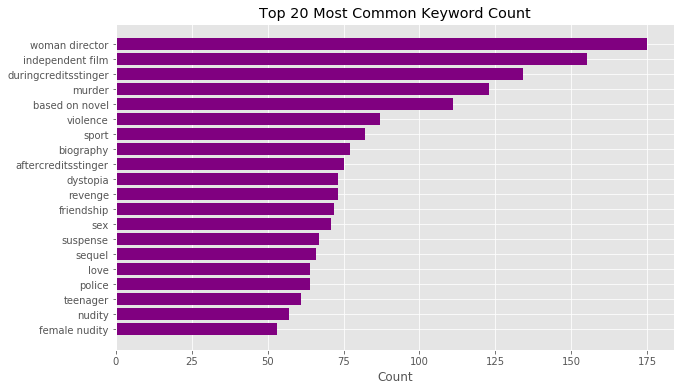

In [120]:
#Plot showing most common keywords in movies.
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_keywords=Counter([i for j in list_of_keywords for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_keywords)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='purple')
plt.xlabel('Count')
plt.title('Top 20 Most Common Keyword Count')
plt.show()

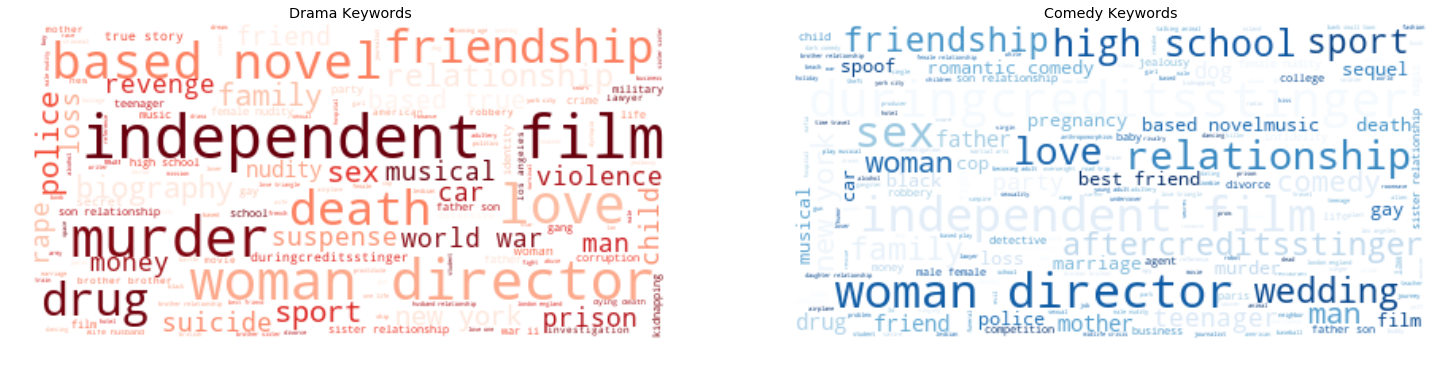

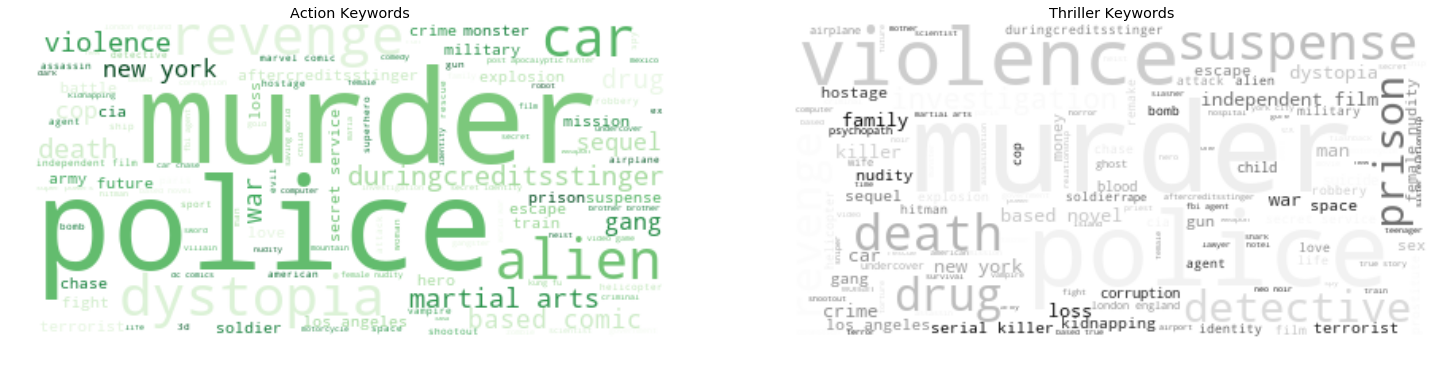

In [121]:
# Text analysis on keywords by top 4 genres


text_drama = " ".join(review for review in drama['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_comedy = " ".join(review for review in comedy['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_action = " ".join(review for review in action['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_thriller = " ".join(review for review in thriller['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))


wordcloud1 = WordCloud(stopwords=stopwords, background_color="white",colormap="Reds").generate(text_drama)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white",colormap="Blues").generate(text_comedy)
wordcloud3 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greens").generate(text_action)
wordcloud4 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greys").generate(text_thriller)


fig = plt.figure(figsize=(25, 20))

plt.subplot(221)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Drama Keywords')
plt.axis("off")

plt.subplot(222)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Comedy Keywords')
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(25, 20))

plt.subplot(223)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.title('Action Keywords')
plt.axis("off")

plt.subplot(224)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.title('Thriller Keywords')
plt.axis("off")
plt.show()


In [122]:
#Handling Categorical value for keywords in dataset.
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

### Cast

In [124]:
#Handling Categorica values for cast names for movies in dataset.
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['all_cast'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(30)]
for g in top_cast_names:
    train['cast_name_' + g] = train['all_cast'].apply(lambda x: 1 if g in x else 0)

    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
test['all_cast'] = test['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_cast_names:
    test['cast_name_' + g] = test['all_cast'].apply(lambda x: 1 if g in x else 0)

Text(0.5, 0, 'Revenue (100 million dollars)')

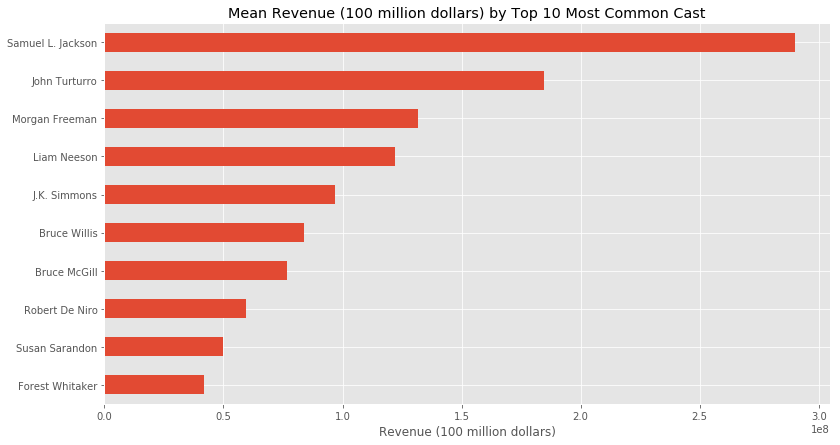

In [125]:
#Mean revenue comparison of 10 most common actor/actress 

cast_name_Samuel_L_Jackson=train.loc[train['cast_name_Samuel L. Jackson']==1,]
cast_name_Robert_De_Niro=train.loc[train['cast_name_Robert De Niro']==1,]
cast_name_Morgan_Freeman=train.loc[train['cast_name_Morgan Freeman']==1,]
cast_name_J_K_Simmons=train.loc[train['cast_name_J.K. Simmons']==1,]
cast_name_Bruce_Willis=train.loc[train['cast_name_Bruce Willis']==1,]
cast_name_Liam_Neeson=train.loc[train['cast_name_Liam Neeson']==1,]
cast_name_Susan_Sarandon=train.loc[train['cast_name_Susan Sarandon']==1,]
cast_name_Bruce_McGill=train.loc[train['cast_name_Bruce McGill']==1,]
cast_name_John_Turturro=train.loc[train['cast_name_John Turturro']==1,]
cast_name_Forest_Whitaker=train.loc[train['cast_name_Forest Whitaker']==1,]


cast_name_Samuel_L_Jackson_revenue=cast_name_Samuel_L_Jackson.mean()['revenue']
cast_name_Robert_De_Niro_revenue=cast_name_Robert_De_Niro.mean()['revenue']
cast_name_Morgan_Freeman_revenue=cast_name_Morgan_Freeman.mean()['revenue']
cast_name_J_K_Simmons_revenue=cast_name_J_K_Simmons.mean()['revenue']
cast_name_Bruce_Willis_revenue=cast_name_Bruce_Willis.mean()['revenue']
cast_name_Liam_Neeson_revenue=cast_name_Liam_Neeson.mean()['revenue']
cast_name_Susan_Sarandon_revenue=cast_name_Susan_Sarandon.mean()['revenue']
cast_name_Bruce_McGill_revenue=cast_name_Bruce_McGill.mean()['revenue']
cast_name_John_Turturro_revenue=cast_name_John_Turturro.mean()['revenue']
cast_name_Forest_Whitaker_revenue=cast_name_Forest_Whitaker.mean()['revenue']


cast_revenue_concat = pd.Series([cast_name_Samuel_L_Jackson_revenue,cast_name_Robert_De_Niro_revenue,cast_name_Morgan_Freeman_revenue,cast_name_J_K_Simmons_revenue,
                                cast_name_Bruce_Willis_revenue,cast_name_Liam_Neeson_revenue,cast_name_Susan_Sarandon_revenue,cast_name_Bruce_McGill_revenue,
                                cast_name_John_Turturro_revenue,cast_name_Forest_Whitaker_revenue])
cast_revenue_concat.index=['Samuel L. Jackson','Robert De Niro','Morgan Freeman','J.K. Simmons','Bruce Willis','Liam Neeson','Susan Sarandon','Bruce McGill',
                            'John Turturro','Forest Whitaker']


fig = plt.figure(figsize=(13, 7))
cast_revenue_concat.sort_values(ascending=True).plot(kind='barh',title='Mean Revenue (100 million dollars) by Top 10 Most Common Cast')
plt.xlabel('Revenue (100 million dollars)')


In [126]:
#Observation:- We see that movies inluding Samuel l. Jackson as actor generated most revenue followed by movies starring
#John Turturro.

In [127]:
#Handling categorical values for cast genders in dataset.
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)


train['genders_0'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    

test['genders_0'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

### Crew

In [128]:
#Handling categorical Values for Movie Crews in dataset.
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
train['all_crew'] = train['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(30)]
for g in top_crew_names:
    train['crew_name_' + g] = train['all_crew'].apply(lambda x: 1 if g in x else 0)

test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
test['all_crew'] = test['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_crew_names:
    test['crew_name_' + g] = test['all_crew'].apply(lambda x: 1 if g in x else 0)

Text(0.5, 0, 'Revenue (100 million dollars)')

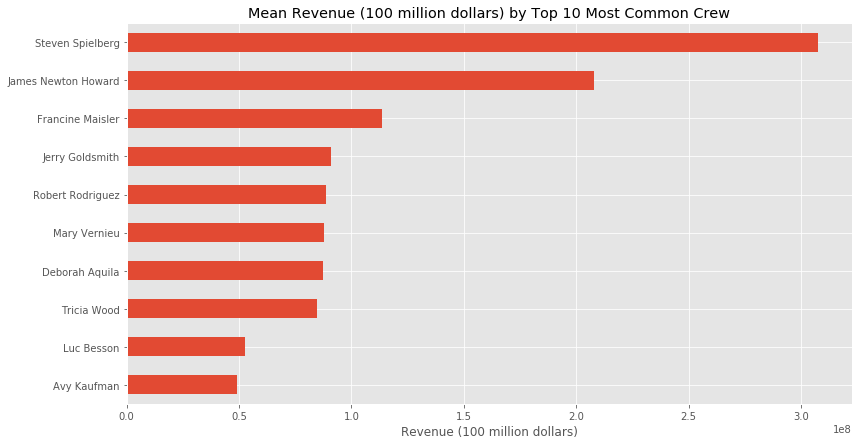

In [129]:
#Mean Revenue generated by movies with particular crews.
crew_name_Avy_Kaufman=train.loc[train['crew_name_Avy Kaufman']==1,]
crew_name_Robert_Rodriguez=train.loc[train['crew_name_Robert Rodriguez']==1,]
crew_name_Deborah_Aquila=train.loc[train['crew_name_Deborah Aquila']==1,]
crew_name_James_Newton_Howard=train.loc[train['crew_name_James Newton Howard']==1,]
crew_name_Mary_Vernieu=train.loc[train['crew_name_Mary Vernieu']==1,]
crew_name_Steven_Spielberg=train.loc[train['crew_name_Steven Spielberg']==1,]
crew_name_Luc_Besson=train.loc[train['crew_name_Luc Besson']==1,]
crew_name_Jerry_Goldsmith=train.loc[train['crew_name_Jerry Goldsmith']==1,]
crew_name_Francine_Maisler=train.loc[train['crew_name_Francine Maisler']==1,]
crew_name_Tricia_Wood=train.loc[train['crew_name_Tricia Wood']==1,]


crew_name_Avy_Kaufman_revenue=crew_name_Avy_Kaufman.mean()['revenue']
crew_name_Robert_Rodriguez_revenue=crew_name_Robert_Rodriguez.mean()['revenue']
crew_name_Deborah_Aquila_revenue=crew_name_Deborah_Aquila.mean()['revenue']
crew_name_James_Newton_Howard_revenue=crew_name_James_Newton_Howard.mean()['revenue']
crew_name_Mary_Vernieu_revenue=crew_name_Mary_Vernieu.mean()['revenue']
crew_name_Steven_Spielberg_revenue=crew_name_Steven_Spielberg.mean()['revenue']
crew_name_Luc_Besson_revenue=crew_name_Luc_Besson.mean()['revenue']
crew_name_Jerry_Goldsmith_revenue=crew_name_Jerry_Goldsmith.mean()['revenue']
crew_name_Francine_Maisler_revenue=crew_name_Francine_Maisler.mean()['revenue']
crew_name_Tricia_Wood_revenue=crew_name_Tricia_Wood.mean()['revenue']


crew_revenue_concat = pd.Series([crew_name_Avy_Kaufman_revenue,crew_name_Robert_Rodriguez_revenue,crew_name_Deborah_Aquila_revenue,crew_name_James_Newton_Howard_revenue,
                                crew_name_Mary_Vernieu_revenue,crew_name_Steven_Spielberg_revenue,crew_name_Luc_Besson_revenue,crew_name_Jerry_Goldsmith_revenue,
                                crew_name_Francine_Maisler_revenue,crew_name_Tricia_Wood_revenue])
crew_revenue_concat.index=['Avy Kaufman','Robert Rodriguez','Deborah Aquila','James Newton Howard','Mary Vernieu','Steven Spielberg','Luc Besson','Jerry Goldsmith',
                            'Francine Maisler','Tricia Wood']


fig = plt.figure(figsize=(13, 7))
crew_revenue_concat.sort_values(ascending=True).plot(kind='barh',title='Mean Revenue (100 million dollars) by Top 10 Most Common Crew')
plt.xlabel('Revenue (100 million dollars)')


In [130]:
#Handeling categorical values for movie crew jobs, genders and departments.
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)


train['genders_0'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['crew_character_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    

    
test['genders_0'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['crew_character_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

## Feature Engineering

Skew of revenue attribute: 4.5


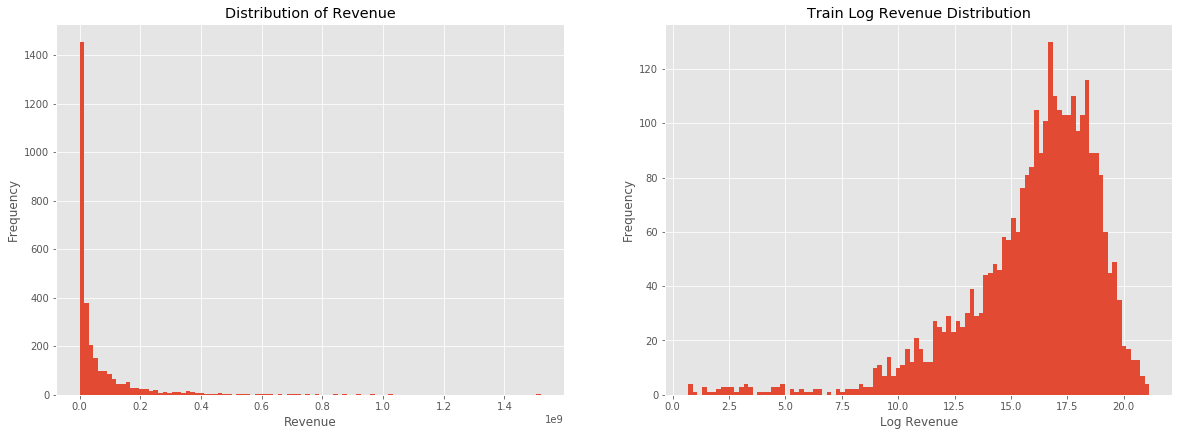

In [133]:
# Plot the distribution of the revenue

fig = plt.figure(figsize=(20, 15))

plt.subplot(221)
train['revenue'].plot(kind='hist',bins=100)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')

plt.subplot(222)
np.log1p(train['revenue']).plot(kind='hist',bins=100)
plt.title('Train Log Revenue Distribution')
plt.xlabel('Log Revenue')


print('Skew of revenue attribute: %0.1f' % skew(train['revenue']))

In [134]:
# Adjusting other skewed variables such as popularity and budget

print('Skew of train budget attribute: %0.1f' % skew(train['budget']))
print('Skew of test budget attribute: %0.1f' % skew(test['budget']))
print('Skew of train popularity attribute: %0.1f' % skew(train['popularity']))
print('Skew of test popularity attribute: %0.1f' % skew(test['popularity']))

Skew of train budget attribute: 3.1
Skew of test budget attribute: 2.7
Skew of train popularity attribute: 14.4
Skew of test popularity attribute: 23.7


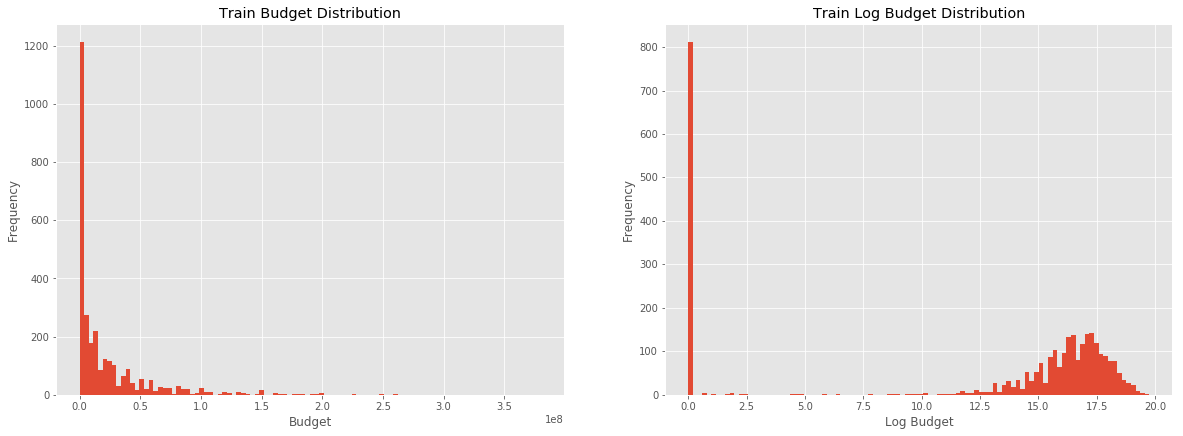

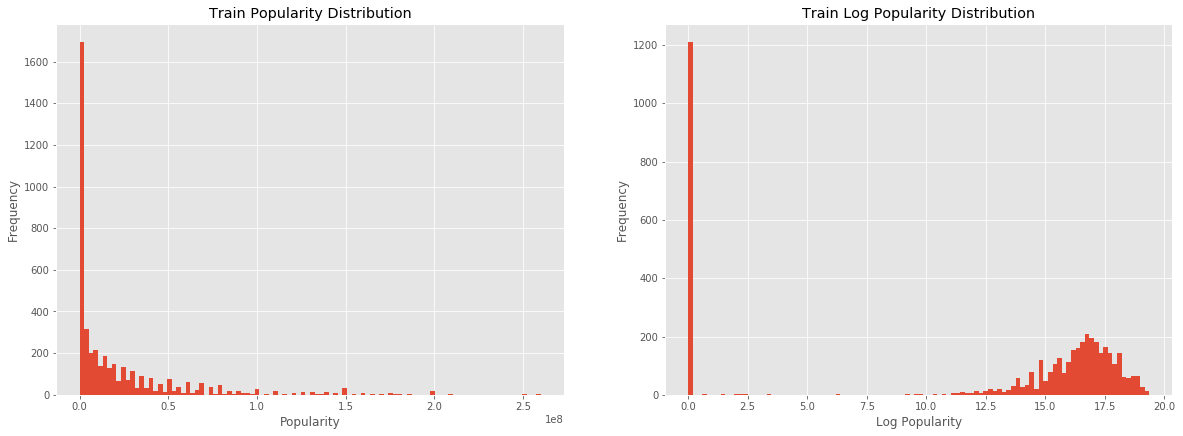

In [137]:
# Before log transformation and after log transformation for train budget and train popularity 
fig = plt.figure(figsize=(20, 15))

plt.subplot(221)
train['budget'].plot(kind='hist',bins=100)
plt.title('Train Budget Distribution')
plt.xlabel('Budget')

plt.subplot(222)
np.log1p(train['budget']).plot(kind='hist',bins=100)
plt.title('Train Log Budget Distribution')
plt.xlabel('Log Budget')

plt.show()

fig = plt.figure(figsize=(20, 15))

plt.subplot(223)
test['budget'].plot(kind='hist',bins=100)
plt.title('Train Popularity Distribution')
plt.xlabel('Popularity')

plt.subplot(224)
np.log1p(test['budget']).plot(kind='hist',bins=100)
plt.title('Train Log Popularity Distribution')
plt.xlabel('Log Popularity')
plt.show()

In [138]:
# Revising budget variable 

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [139]:
# Putting log variables for skewed data 
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])
train['log_popularity']=np.log1p(train['popularity'])
test['log_popularity']=np.log1p(test['popularity'])

In [140]:
def prepare(df):
    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['_year_to_log_budget'] = df['release_year'] / df['log_budget']
    df['_year_to_log_popularity'] = df['release_year'] / df['log_popularity']

    df['has_homepage'] = 0
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 
    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')

    return df

train_new=prepare(train)
test_new=prepare(test)

In [141]:
#Drop the columns that are not needed.
drop_columns=['homepage','imdb_id','poster_path','status','title', 'release_date','tagline', 'overview', 'original_title','all_genres','all_cast',
             'original_language','collection_name','all_crew']
train_new=train_new.drop(drop_columns,axis=1)
test_new=test_new.drop(drop_columns,axis=1)

In [142]:
print( "updated train dataset:", train_new.shape,"\n","updated test dataset: ",test_new.shape)

updated train dataset: (3000, 289) 
 updated test dataset:  (4398, 288)


In [217]:
# Formating for modeling
train_new = train_new[np.isfinite(train_new).all(1)]
test_new = test_new[np.isfinite(test_new).all(1)]
X = train_new.drop(['id', 'revenue'], axis=1)
y = np.log1p(train_new['revenue'])
X_test = test_new.drop(['id'], axis=1)

In [218]:
#Handling Missing values
X.fillna(X.mean(), inplace = True)
y.fillna(y.mean(), inplace = True)
X_test.fillna(X_test.mean(), inplace = True)

In [219]:
X = X.drop('meanBudgetByYear', axis = 1)
X.head()

,budget,popularity,runtime,num_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,...,isTaglineNA,isTitleDifferent,isMovieReleased,original_title_letter_count,original_title_word_count,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear
1921,5000000,8.898523,84.0,2,0,0,1,0,0,0,...,0,0,1,36,5,5,40.0,5.0,68.000000,8.168456
1924,65000000,9.170332,145.0,3,1,1,0,0,1,0,...,0,0,1,16,4,4,35.0,3.0,149.000000,3.878515
1926,28000000,9.765123,127.0,3,0,0,1,1,0,0,...,0,0,1,18,4,4,35.0,8.0,84.000000,0.445526
1928,25000000,11.872997,93.0,2,0,0,0,0,0,0,...,0,0,1,19,3,3,29.0,8.0,53.666667,0.357398
1930,65000000,13.268484,159.0,2,1,0,0,0,0,0,...,0,0,1,14,3,3,47.0,3.0,63.000000,2.761450


In [222]:

#Splitting into train, test sets
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

## Training The Model

### Decision Tree Regression

In [223]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [232]:
y_pred = regressor.predict(X_test)

In [247]:
predictions = pd.DataFrame({'Actual Revenue':y_test,'Predicted Predicted':y_pred})

In [248]:
predictions.head()

,Actual Revenue,Predicted Predicted
2017,15.912152,16.882947
1984,19.236006,18.765834
2011,18.066859,17.159837
1973,14.567134,18.274063
1943,17.079581,15.684570


### Random Forest Regression

In [235]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300,random_state = 0)
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [246]:
#Predictions
y_pred2 = regressor.predict(x_test)
predictions2 = pd.DataFrame({'Actual Revenue':y_test, 'Predicted Revenue':y_pred2})
predictions2.head()

,Actual Revenue,Predicted Revenue
2017,15.912152,17.486471
1984,19.236006,18.284536
2011,18.066859,17.573282
1973,14.567134,17.184921
1943,17.079581,17.954628


### XG-Boost

In [245]:
#XG-BOOST
import xgboost
model = xgboost.XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [249]:
#Predictions
y_pred3 = regressor.predict(x_test)
predictions3 = pd.DataFrame({'Actual Revenue':y_test, 'Predicted Predicted':y_pred3})
predictions3.head()

,Actual Revenue,Predicted Predicted
2017,15.912152,17.486471
1984,19.236006,18.284536
2011,18.066859,17.573282
1973,14.567134,17.184921
1943,17.079581,17.954628
